# Project: Advanced Lane Finding

## Import Packages

In [1]:
import pickle
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


## Camera Calibration

### 1.Import calibration images 

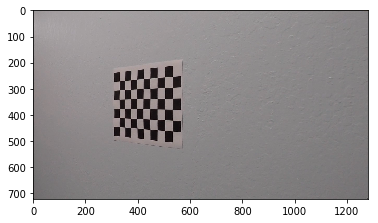

In [2]:
images = glob.glob('camera_cal/calibration*.jpg')

# sample image
img = cv2.imread(images[3])
plt.imshow(img)
nx = 9
ny = 6



### 2. Find corners and generate camera matrix

[[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259867]]


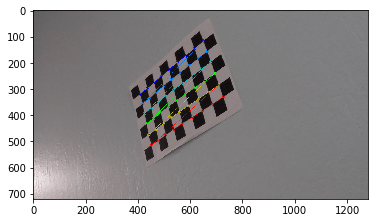

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        '''if idx ==3:
            write_name = 'corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)'''
        plt.imshow(img)
        #plt.pause(0.5)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)
print(dist)



### 3. Undistort

In [4]:
# Define a function that takes an image, number of x and y points, camera matrix and distortion coefficients, and undistort it
def undistort(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

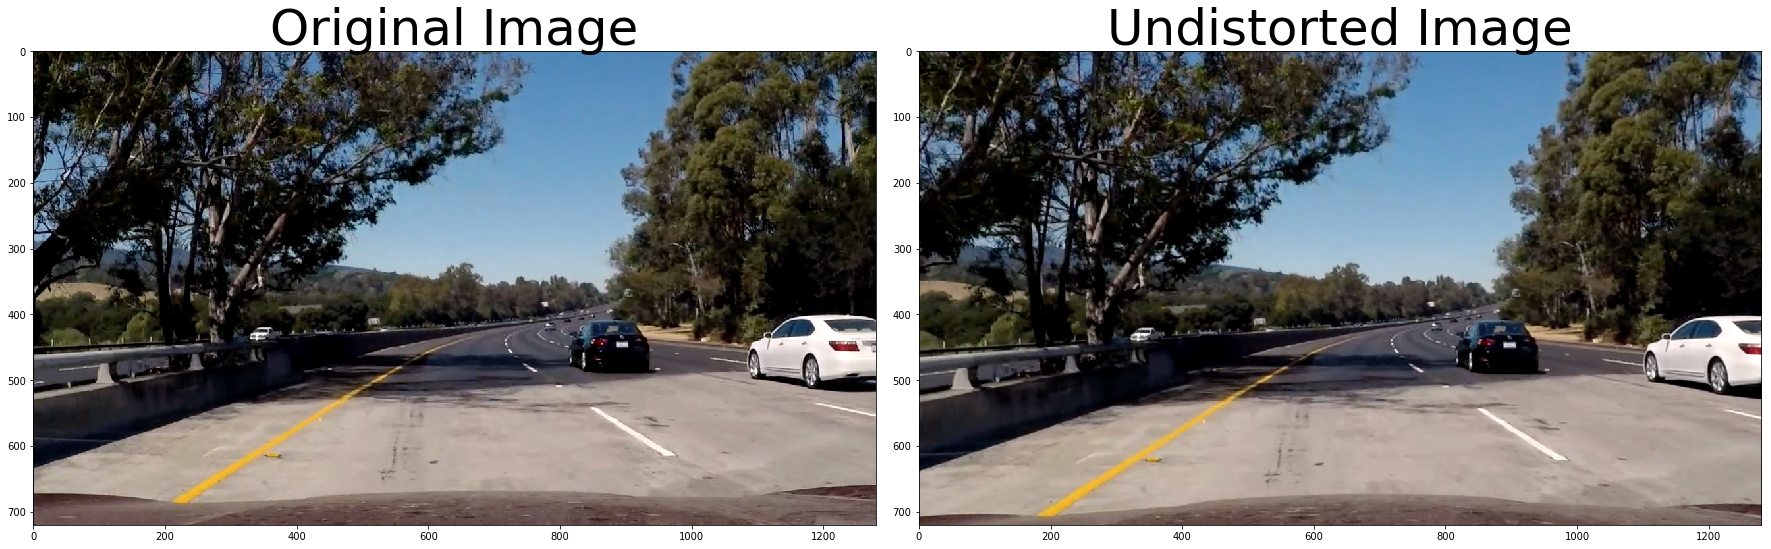

In [5]:
#test 
test_images = glob.glob('test_images/*.jpg')
img = mpimg.imread(test_images[1])
undist_img = undistort(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('output_images/Undistortion_test_images.png')

## Color and Gradient Thresholding

In [6]:
#import test images

test_images = glob.glob('test_images/*.jpg')


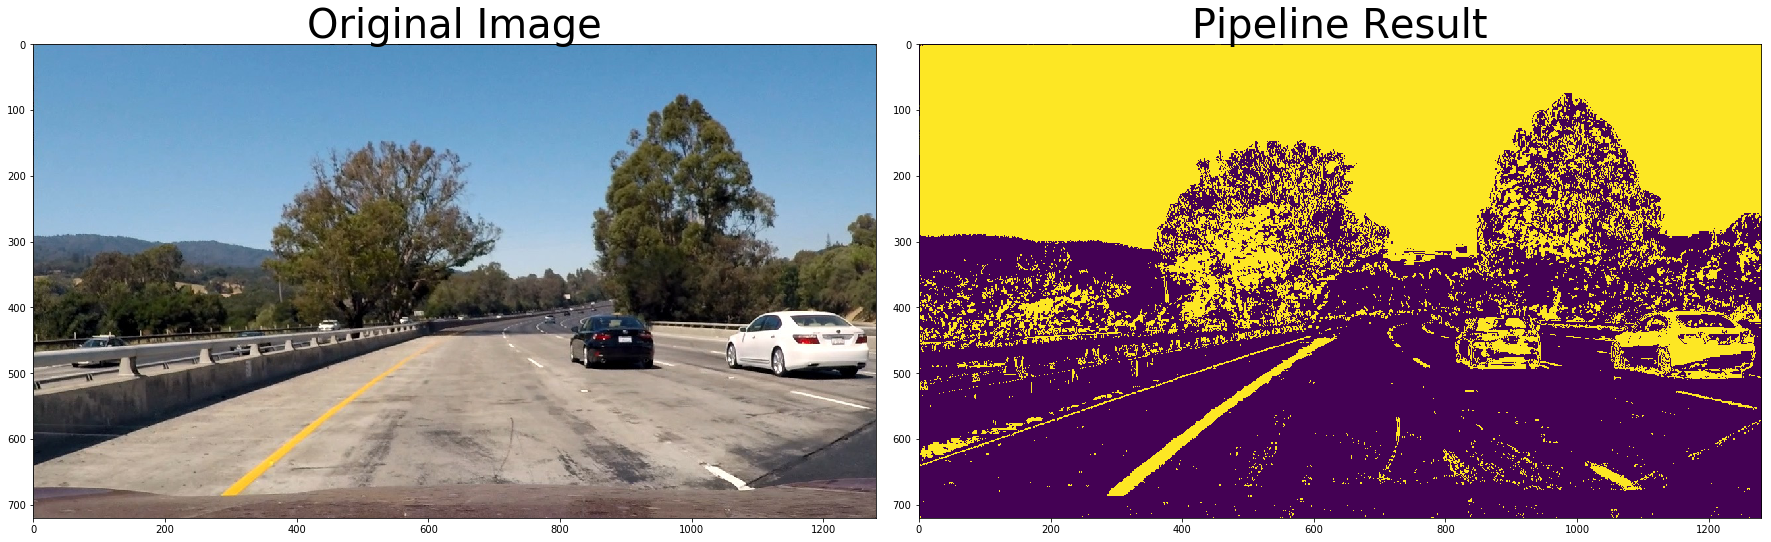

In [7]:
def thresh_pipeline(img, s_thresh=(90, 255), sx_thresh=(20, 100),dir_thresh=(0.8, 1.3)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from horizontal   
    # Sobel Direction
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold direction gradient
    dirbinary = np.zeros_like(absgraddir)
    dirbinary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] =1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    #color_binary = s_binary * 255
    #color_binary = dirbinary*255
    color_binary = np.zeros_like(sxbinary+s_binary)
    color_binary[(sxbinary+s_binary)>0] =1 
    return color_binary
    

# Plot the result
for idx, fname in enumerate(test_images[0:1]):
    test_img = mpimg.imread(fname)
    result = thresh_pipeline(test_img)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(test_img)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result)
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.savefig('output_images/threshold_test_images.png')
    #plt.pause(0.5)

## Perspective Transform

(720, 1280, 3)


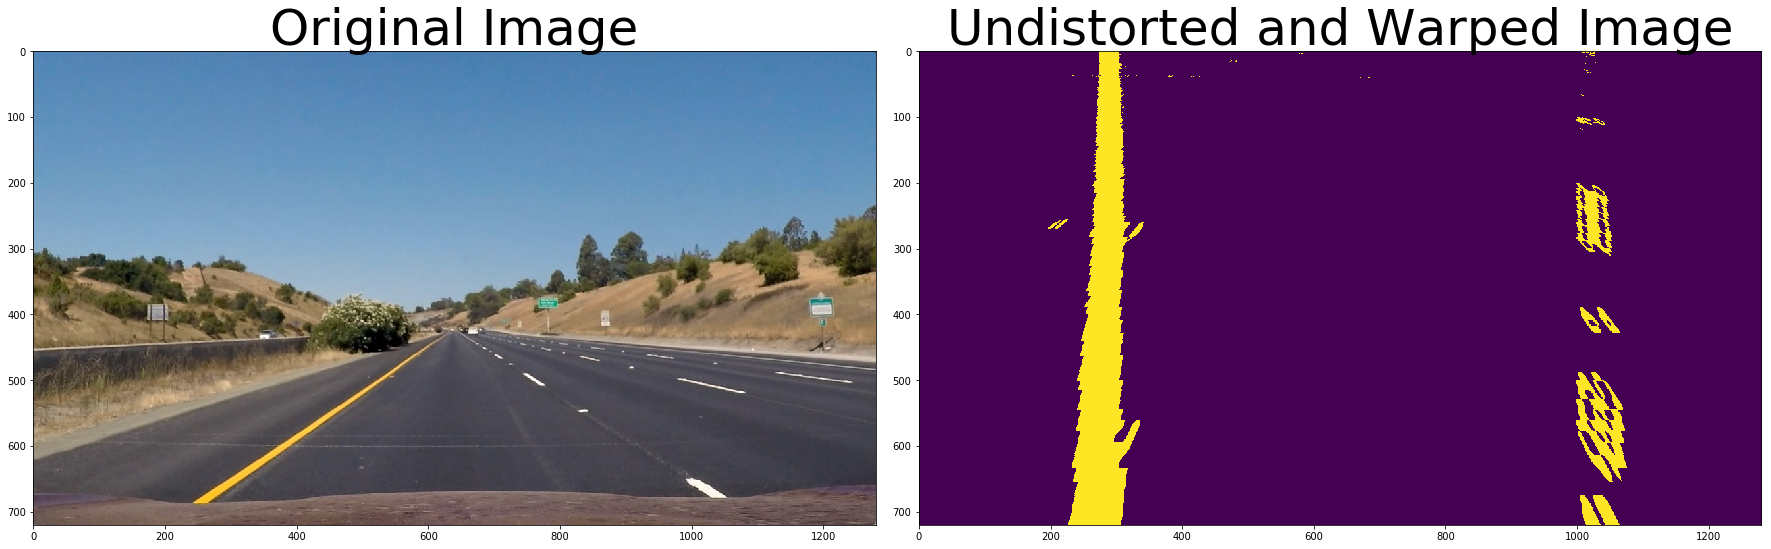

In [11]:
# import straight line images for perspective calibration
straight_images = glob.glob('test_images/straight_lines*.jpg')
straight_img = mpimg.imread(straight_images[0])
test_img = mpimg.imread(test_images[5])

def corners_unwarp(undist):
    # Convert undistorted image to grayscale
    thresh_binary = thresh_pipeline(undist)
    # pixels read from http://arohatgi.info/WebPlotDigitizer/app3_12/ 
    x1 = 286.5
    x2 = 1019.5
    x3 = 609.7
    x4 = 670.3
    y1 = 663.8
    y2 = 442.2
    img_size = (thresh_binary.shape[1],thresh_binary.shape[0])
    corners = [[x1, y1],[x3, y2],[x4, y2],[x2, y1]]
    src = np.float32(corners)
    dst = np.float32([[x1, 0], [x1,img_size[0]],[x2, img_size[0]], [x2, 0]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(thresh_binary, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv
undist_img = undistort(straight_img, nx, ny, mtx, dist)
top_down, perspective_M, Minv = corners_unwarp(undist_img)
#show example
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(straight_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/WarpedImage.png')
print(test_img.shape)

## Finding the Lines

### window searching

Left Fit Coefficient = [  2.22329881e-04   2.39074008e-02   1.49173594e+00]
Right Fit Coefficient = [  2.14911696e-04   2.72342986e-02   4.93844300e+00]
offset = 0.273835586118
left radius = 2253.58750199
right_radius = 2332.15394488
1280


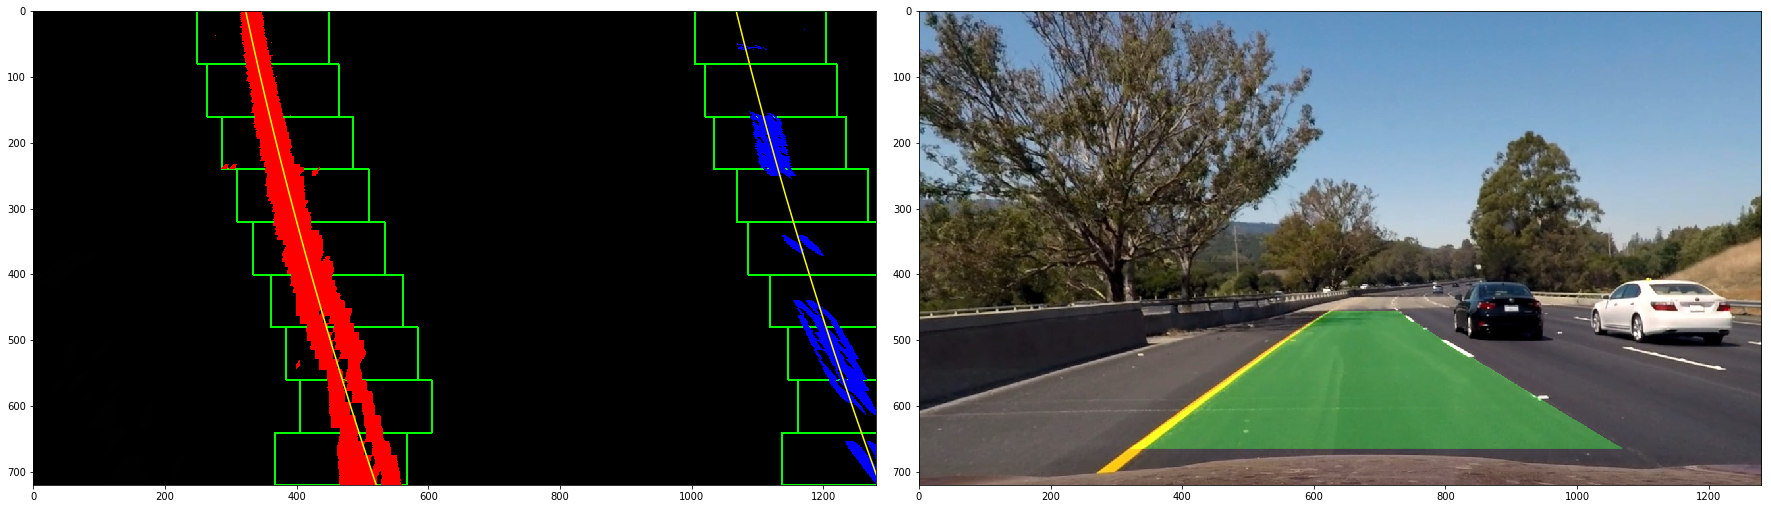

In [22]:

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # real measurement
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    ploty = np.linspace(0, 719, num=720)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    y_eval = np.max(ploty)
    print('Left Fit Coefficient =',left_fit_cr)
    print('Right Fit Coefficient =',right_fit_cr)
    #   Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
     ### offset
    left_bottom = left_fitx[0]
    right_bottom = right_fitx[0]
    offset = ((left_bottom+right_bottom)/2-binary_warped.shape[1]/2)*3.7/((-left_bottom+right_bottom))
    print('offset =',offset)
    print('left radius =',left_curverad)
    print('right_radius =',right_curverad)
    print(binary_warped.shape[1])
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    ax1.plot(left_fitx, ploty, color='yellow')
    ax1.plot(right_fitx, ploty, color='yellow')
    
    ### Visual Original
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    return out_img,left_curverad,right_curverad,pts
for idx, fname in enumerate(test_images[6:7]):
    test_img = mpimg.imread(fname)
    undist = undistort(test_img, nx, ny, mtx, dist)
    warped, perspective_M, Minv = corners_unwarp(undist)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    out_img,left_curverad,right_curverad,pts = fit_polynomial(warped)
    #print(left_curverad,right_curverad)
    ax1.imshow(out_img)
    
    ### Visualization on original image
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (test_img.shape[1], test_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    ax2.imshow(result)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    plt.savefig('output_images/FitImage.png')




In [23]:
def fit_polynomial_clean(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # real measurement
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/750 # meters per pixel in x dimension
    ploty = np.linspace(0, 719, num=720)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    y_eval = np.max(ploty)
    #   Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ### Visual Original
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    ### offset
    left_bottom = left_fitx[0]
    right_bottom = right_fitx[0]
    offset = ((left_bottom+right_bottom)/2-binary_warped.shape[1]/2)*xm_per_pix
    return left_curverad,right_curverad,pts,offset

### Draw Lines

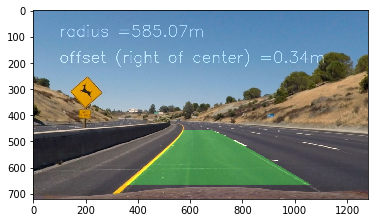

In [24]:
def pipeline(img):
    global mtx
    global dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped, perspective_M,Minv = corners_unwarp(undist)
    left_curverad,right_curverad,pts,offset = fit_polynomial_clean(warped)
    ### Visualization on original image
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (test_img.shape[1], test_img.shape[0])) 
    # Combine the result with the original image
    s = 'radius ='+'{0:.2f}'.format(left_curverad)+'m'
    s2 = 'offset (right of center) ='+ '{0:.2f}'.format(offset)+'m'
    add_text= cv2.putText(newwarp,s, (100,100), cv2.FONT_HERSHEY_SIMPLEX,  2,(255,255,255),2,cv2.LINE_AA)
    add_text= cv2.putText(add_text,s2, (100,200), cv2.FONT_HERSHEY_SIMPLEX,  2,(255,255,255),2,cv2.LINE_AA)

    result = cv2.addWeighted(undist, 1, add_text, 0.3, 0)
    return result
# Test the pipeline function    
img = mpimg.imread(test_images[7])
result = pipeline(img)
plt.imshow(result)

# Test on Videos

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 98%|█████████▊| 1239/1261 [06:16<00:06,  3.34it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))